<a href="https://www.kaggle.com/code/pratul007/textanalysis-sentiment-ner-topics-summary?scriptVersionId=139019892" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

1. **Environment Setup:** Install the necessary packages and import the required libraries.

2. **Model Loading:** Load a pre-trained model using the Hugging Face transformers library.

3. **Device Setup:** Check if a GPU is available and, if so, move the model to the GPU for faster computation.

4. **Data Loading:** Load a dataset of reviews into a pandas DataFrame.

5. **Data Cleaning:** Remove any non-numeric ratings and convert the remaining ratings to integers. Also add a new column that measures the length of each review.

6. **Exploratory Data Analysis:** Plot histograms of the ratings and review lengths to understand their distributions. Additionally, tokenize the reviews and calculate the frequency of each word to identify the most common words.

7. **Sentiment Analysis:** Split the review text into chunks and apply a sentiment analysis model to each chunk. Calculate the average sentiment score for each review and assign an overall sentiment label. Add new columns to the DataFrame to store these results.

8. **Text Preprocessing:** Tokenize and clean the review text in preparation for topic modeling. This includes removing stop words and words that are too common or too rare.

9. **Topic Modeling:** Use Latent Dirichlet Allocation (LDA) to identify common topics in the reviews. Print the top words for each topic and generate word clouds to visualize these topics.

10. **Named Entity Recognition (NER):** Apply a NER model to each review to identify and classify named entities. Add a new column to the DataFrame to store these entities.

11. **Entity Analysis:** Extract all identified entities and count their frequencies to identify the most common entity types.

12. **Text Summarization:** Apply a text summarization model to each review to generate a short summary. Add a new column to the DataFrame to store these summaries.

13. **Saving Results:** Finally, save the DataFrame with the sentiment analysis, NER, and summarization results to a CSV file for further analysis or reporting.Here is a flowchart representing the process you described:

![Flowchart](https://lucid.app/ai/plugin/images/aiplugin_355e6d61-d62e-4446-8e3f-f2e155da450f)



In [1]:
! pip install transformers

Checking the Availability of GPU

In [2]:
import torch
from transformers import AutoModel

model = AutoModel.from_pretrained('bert-base-uncased')

# Check GPU availability and move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(next(model.parameters()).device)  # This should print 'cuda:0' if the model is using a GPU

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


cuda:0


# Data Loading

In [3]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/kaggle/input/imdb-reviews-on-barbie/barbie_Cleaned.csv')

# Display the first 5 rows of the dataset
df.head()

,text,rating
0,"Beautiful film, but so preachyLoveofLegacy21 J...",6
1,Clever and fun beginning turns into another le...,6
2,It was depressingcoxaneesa24 July 2023Warning:...,8
3,A Technicolor Dreamheatherhilgers24 July 2023W...,9
4,reasons FOR seeing it and 1 reason AGAINST.im...,7


In [4]:
# Checking for missing values
missing_values = df.isnull().sum()

# Analyzing the distribution of ratings
rating_distribution = df['rating'].value_counts(normalize=True)

missing_values, rating_distribution

(text      0
 rating    0
 dtype: int64,
 1    0.331242
 8    0.149310
 6    0.112923
 7    0.109159
 9    0.101631
 5    0.062735
 3    0.048934
 4    0.046424
 2    0.028858
 H    0.001255
 B    0.001255
 P    0.001255
 M    0.001255
 D    0.001255
 T    0.001255
 A    0.001255
 Name: rating, dtype: float64)

# Rating and Review Distribution

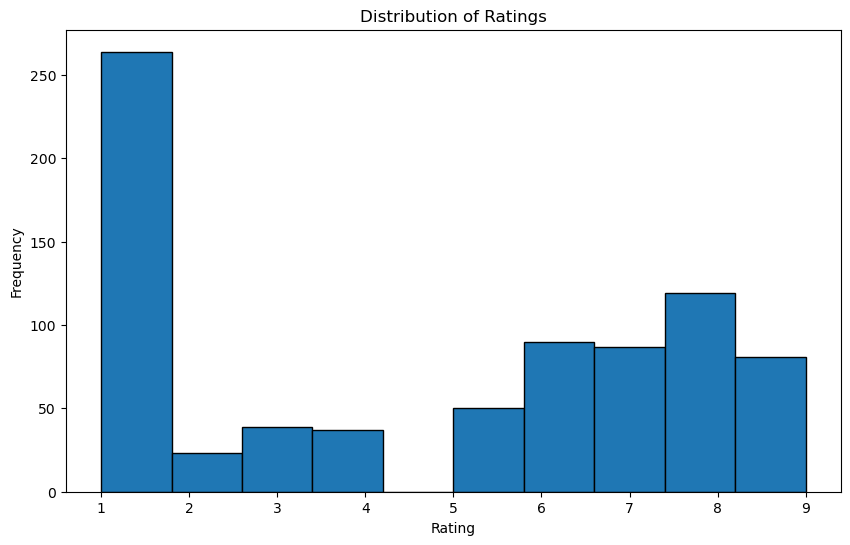

In [5]:
import matplotlib.pyplot as plt

# Removing non-numeric ratings
df = df[df['rating'].str.isnumeric()]

# Converting ratings to integers
df['rating'] = df['rating'].astype(int)

# Plotting histogram of ratings
plt.figure(figsize=(10, 6))
plt.hist(df['rating'], bins=10, edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

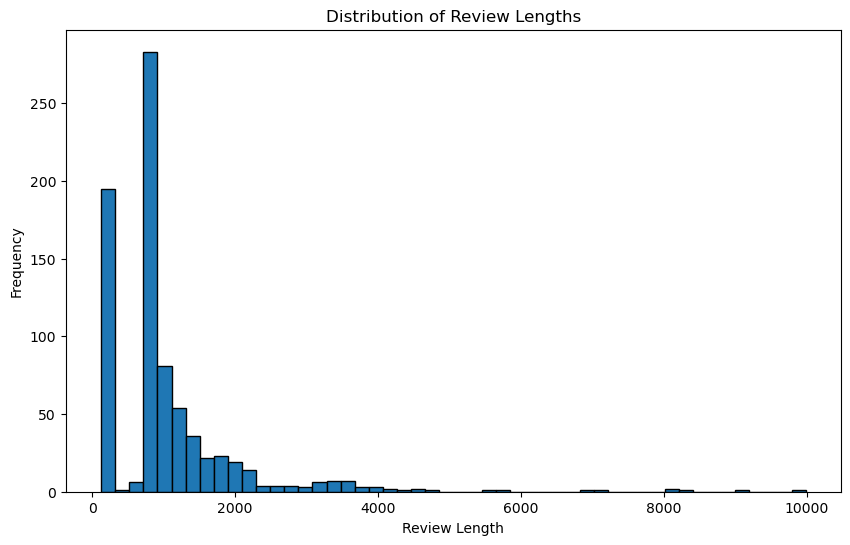

In [6]:
# Adding a new column for review length
df['review_length'] = df['text'].apply(len)

# Plotting histogram of review lengths
plt.figure(figsize=(10, 6))
plt.hist(df['review_length'], bins=50, edgecolor='black')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

# Most Common Words

In [7]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk

# Download the stopwords from NLTK
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Tokenize the reviews and remove stop words
words = []
for review in df['text']:
    for word in word_tokenize(review):
        word = word.lower()
        if word.isalpha() and word not in stop_words and len(word) > 2:
            words.append(word)

# Count the frequency of each word
word_counts = Counter(words)

# Get the 10 most common words
common_words = word_counts.most_common(10)

common_words

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('movie', 1811),
 ('barbie', 1624),
 ('helpful', 1581),
 ('film', 894),
 ('found', 832),
 ('review', 818),
 ('july', 792),
 ('sign', 791),
 ('like', 477),
 ('world', 449)]

# Sentiment Analysis

In [8]:
from transformers import AutoTokenizer, pipeline

# Load the sentiment analysis pipeline with the specified model
sentiment_analysis = pipeline("sentiment-analysis", model="wesleyacheng/movie-review-sentiment-classifier-with-bert")

# Initialize the tokenizer with the same model
tokenizer = AutoTokenizer.from_pretrained("wesleyacheng/movie-review-sentiment-classifier-with-bert")

# Function to split the text into chunks of max_length
def chunk_text(text, max_length=510):
    # Tokenize the text
    tokens = tokenizer.encode(text, truncation=False)

    # Split the tokens into chunks of max_length
    chunks = [tokens[i:i + max_length] for i in range(0, len(tokens), max_length)]

    # Decode the tokens to strings
    chunks = [tokenizer.decode(chunk) for chunk in chunks]

    return chunks

# Function to apply sentiment analysis to each chunk and average the results
def apply_sentiment_analysis(text):
    chunks = chunk_text(text)
    sentiments = [sentiment_analysis(chunk)[0] for chunk in chunks]

    # Calculate the average sentiment score and determine the overall label
    avg_score = sum(sentiment['score'] for sentiment in sentiments) / len(sentiments)
    overall_label = 'POSITIVE' if avg_score >= 0.5 else 'NEGATIVE'

    return {'label': overall_label, 'score': avg_score}

# Apply the sentiment analysis function to each review
df['sentiment_result'] = df['text'].apply(apply_sentiment_analysis)

# Extract the label and score from the result
df['sentiment'] = df['sentiment_result'].apply(lambda x: x['label'])
df['sentiment_score'] = df['sentiment_result'].apply(lambda x: x['score'])

# Drop the intermediate column
df = df.drop(columns=['sentiment_result'])

# Display the first few rows
df.head()

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
Token indices sequence length is longer than the specified maximum sequence length for this model (588 > 512). Running this sequence through the model will result in indexing errors


,text,rating,review_length,sentiment,sentiment_score
0,"Beautiful film, but so preachyLoveofLegacy21 J...",6,929,POSITIVE,0.981157
1,Clever and fun beginning turns into another le...,6,777,POSITIVE,0.876962
2,It was depressingcoxaneesa24 July 2023Warning:...,8,140,POSITIVE,0.562490
3,A Technicolor Dreamheatherhilgers24 July 2023W...,9,1361,POSITIVE,0.986445
4,reasons FOR seeing it and 1 reason AGAINST.im...,7,164,POSITIVE,0.543840


In [9]:
df.to_csv('/kaggle/working/barbie_reviews_sentiment.csv', index=False)

# Sentiment Score Distribution

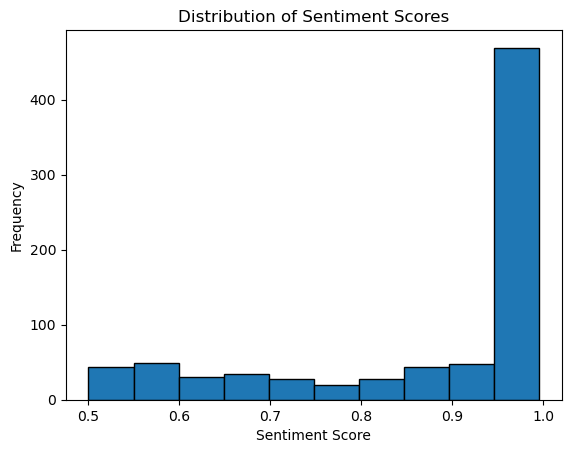

In [10]:
import matplotlib.pyplot as plt

# Assuming df_sentiment is your DataFrame and 'sentiment_score' is the column with sentiment scores
plt.hist(df['sentiment_score'], bins=10, edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# Topic Modelling

In [11]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# Function to perform the pre processing steps on the entire dataset
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

# Preprocess the text column and save the results as a new column
df['processed_text'] = df['text'].map(preprocess)

# Create a dictionary representation of the documents, and filter out frequent and rare words.
dictionary = gensim.corpora.Dictionary(df['processed_text'])

# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Create the Bag-of-words model for each document i.e for each document we create a dictionary reporting how many
# words and how many times those words appear. Save this to 'bow_corpus'
bow_corpus = [dictionary.doc2bow(doc) for doc in df['processed_text']]

# Train the LDA model
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

# Print the top topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Topic: 0 
Words: 0.021*"film" + 0.020*"good" + 0.015*"like" + 0.009*"great" + 0.009*"gosling" + 0.009*"ryan" + 0.008*"time" + 0.008*"think" + 0.007*"world" + 0.007*"story"
Topic: 1 
Words: 0.025*"film" + 0.014*"world" + 0.012*"great" + 0.009*"real" + 0.008*"like" + 0.006*"perfect" + 0.006*"gerwig" + 0.006*"funny" + 0.006*"audience" + 0.005*"greta"
To

# Topic Modelling Word Cloud

The plot for the 0 topic


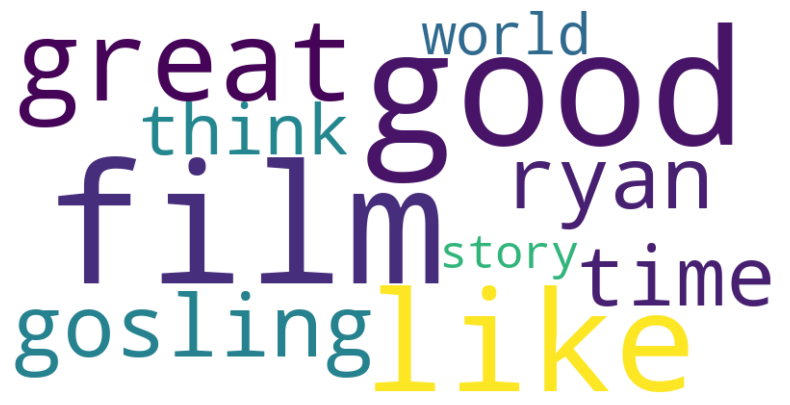

The plot for the 1 topic


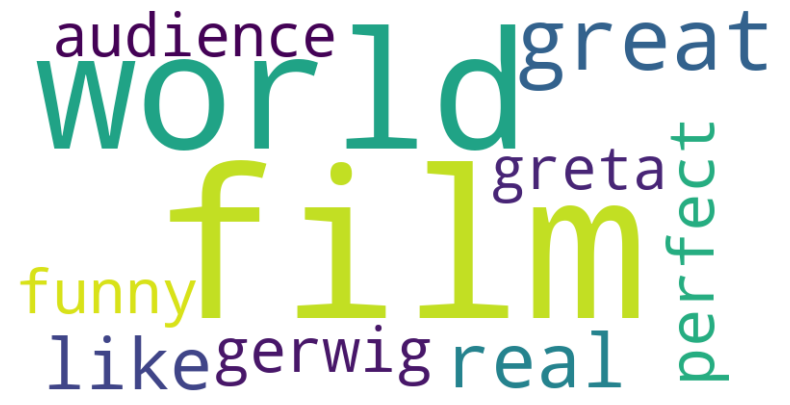

The plot for the 2 topic


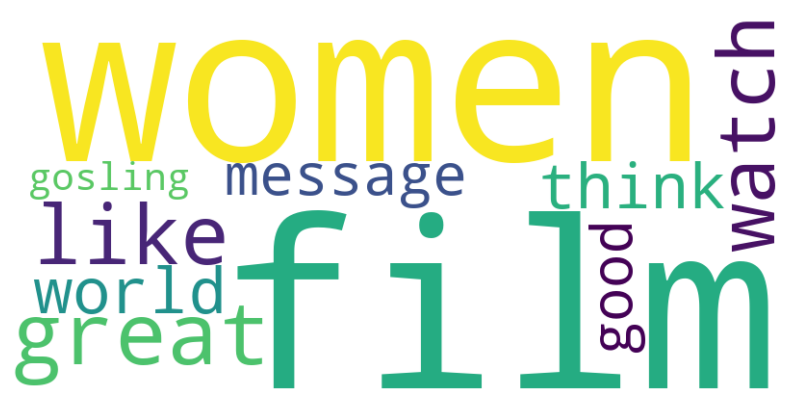

The plot for the 3 topic


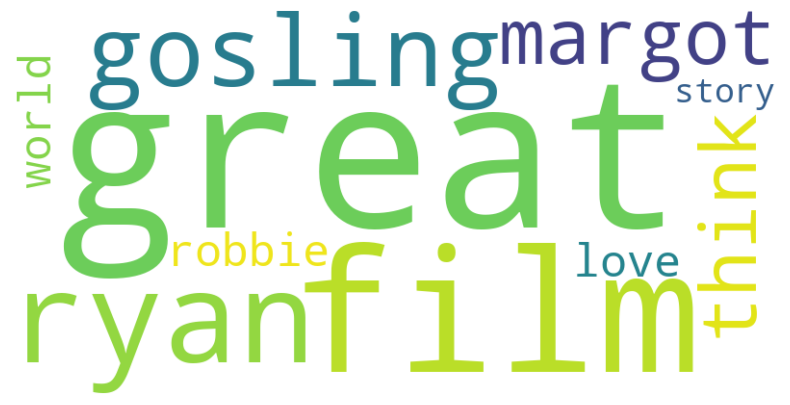

The plot for the 4 topic


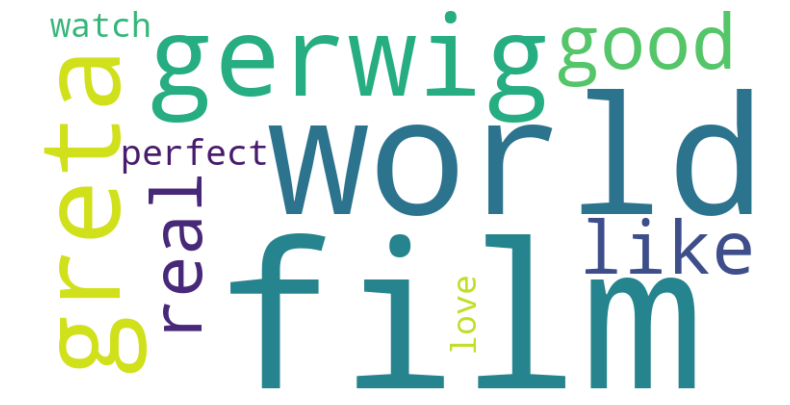

The plot for the 5 topic


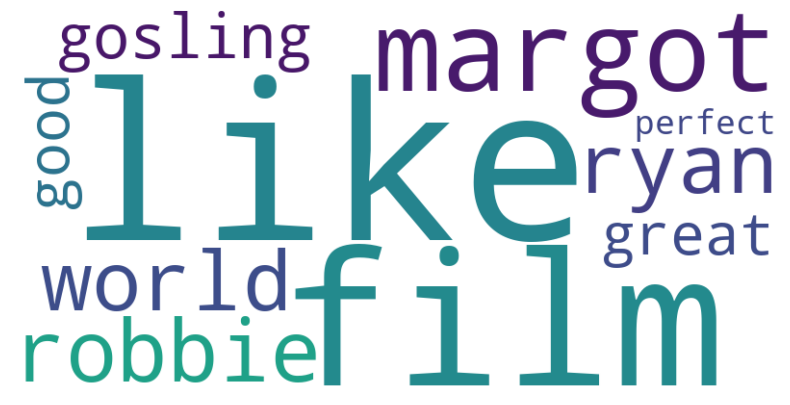

The plot for the 6 topic


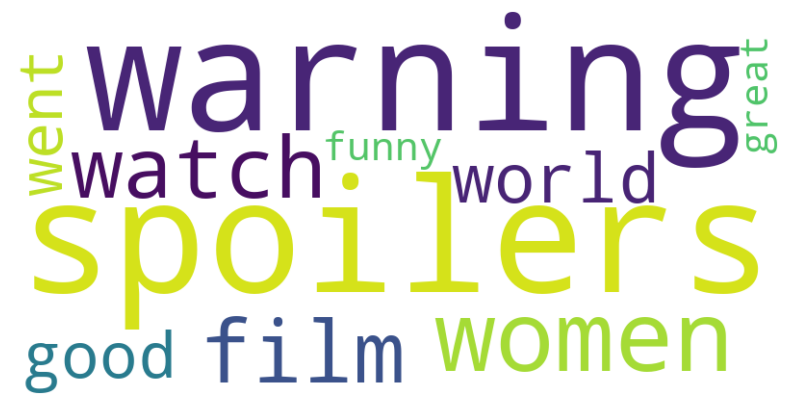

The plot for the 7 topic


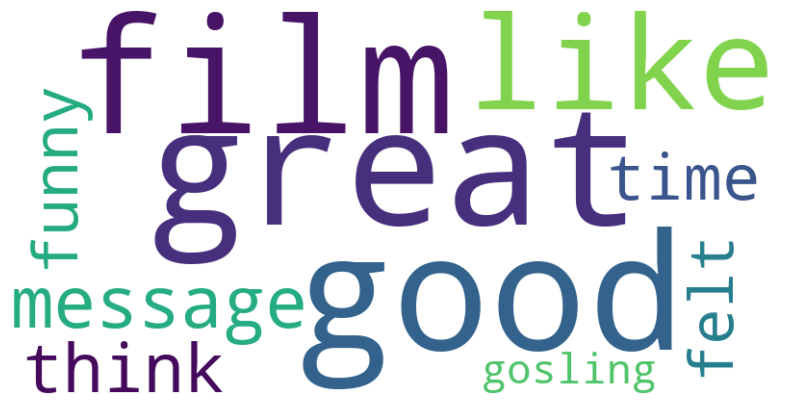

The plot for the 8 topic


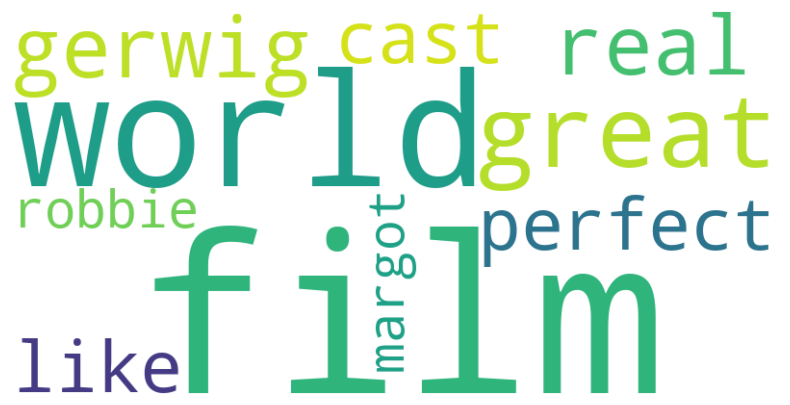

The plot for the 9 topic


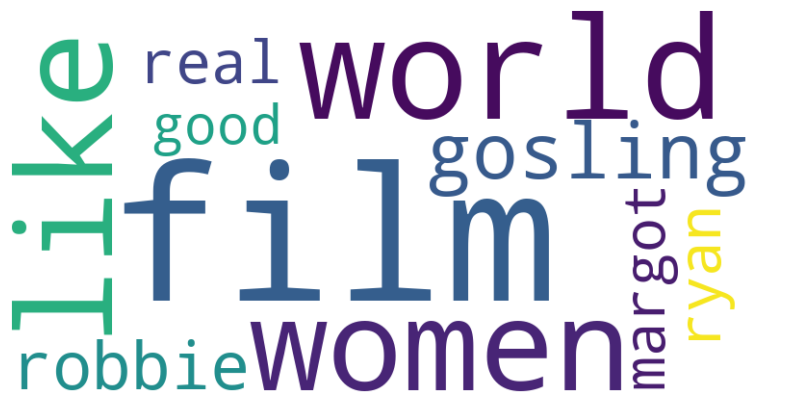

In [12]:
from wordcloud import WordCloud
for i in range(0,10):
    # Select a topic
    topic = lda_model.show_topic(i)

    # Convert the topic into a format suitable for the word cloud function
    word_freq = {word: freq for word, freq in topic}

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    # Display the word cloud
    print(f'The plot for the {i} topic')
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Name Entity Recognition

In [13]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the NER pipeline
ner = pipeline("ner", grouped_entities=True, device=0 if device.type == 'cuda' else -1)

# Apply the NER pipeline to each review
df['entities'] = df['text'].apply(ner)

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/token_classification.py:169: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="simple"` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [14]:
df.to_csv('/kaggle/working/barbie_reviews_sentiment_ner.csv', index=False)

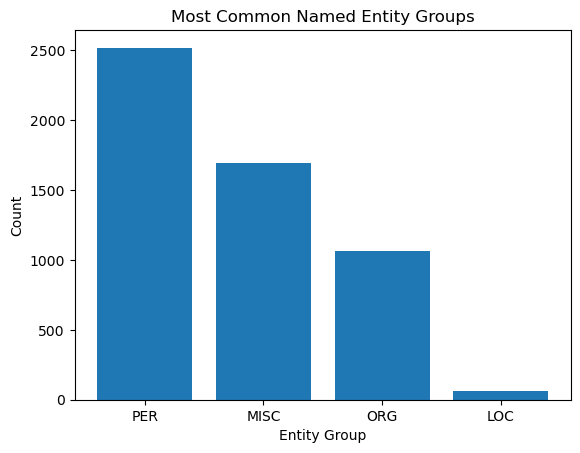

In [15]:
from collections import Counter
import matplotlib.pyplot as plt

# Extract all entity groups from the 'entities' column
all_entities = [entity['entity_group'] for entities in df['entities'] for entity in entities]

# Count the frequency of each entity group
entity_counts = Counter(all_entities)

# Get the 10 most common entity groups
common_entities = entity_counts.most_common(10)

# Create a bar plot of the most common entity groups
plt.bar(*zip(*common_entities))
plt.xlabel('Entity Group')
plt.ylabel('Count')
plt.title('Most Common Named Entity Groups')
plt.show()

* **'PER'** for person with the Highest
* **'ORG'** for organization Third Highest
* **'MISC'** for miscellaneous Second Highest

# Text Summarization

In [16]:
import torch
from transformers import pipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the summarization pipeline with the specified model
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=0 if device.type == 'cuda' else -1)

# Function to apply the summarizer and extract the summary text
def summarize_review(review):
    # Calculate max_length as 80% of the review length, but at least 20 and not more than 512
    max_length = min(max(int(len(review.split()) * 0.8), 20), 512)

    # Calculate min_length as 40% of the max_length, but at least 10 and not more than 128
    min_length = min(max(int(max_length * 0.4), 10), 128)

    # Generate the summary
    summary = summarizer(
        review,
        min_length=min_length,
        max_length=max_length,
        do_sample=False,
        truncation=True
    )

    return summary[0]['summary_text']

# Apply the summarization function to each review
df['summary'] = df['text'].apply(summarize_review)

/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [17]:
df.to_csv('/kaggle/working/barbie_reviews_sentiment_ner_summarization.csv', index=False)

## **Please upvote and comments for improvement**